L1正则化：lasso回归

L2正则化：岭回归

使用L2范数的一个原因是它对权重向量的大分量施加了巨大的惩罚。这使得我们的学习算法偏向于在大量特征上均匀分布权重的模型。在实践中，这可能使它们对单个变量中的观测误差更为稳定。

L1范数会导致模型将权重集中在一小部分特征上，而将其他权重清除为零。 这称为特征选择（feature selection），这可能是其他场景下需要的。

通常，网络输出层的偏置项不会被正则化。

In [23]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

In [24]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [25]:
def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

L2正则化

In [26]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [27]:
def train(lambd):
    w, b = init_params()
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, 0.003
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            # 增加了L2范数惩罚项，
            # 广播机制使l2_penalty(w)成为一个长度为batch_size的向量
            l = loss(net(X), y) + lambd * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1, (d2l.evaluate_loss(net, train_iter, loss),
                                     d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数是：', torch.norm(w).item())

不用L2正则化项的话，结果会产生严重的过拟合

w的L2范数是： 13.1217041015625


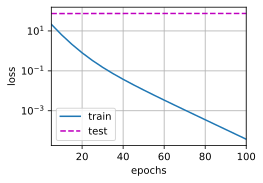

In [28]:
train(lambd=0)

w的L2范数是： 0.373692125082016


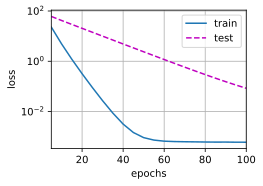

In [29]:
train(lambd=3)

In [30]:
def train_concise(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in net.parameters():
        param.data.normal_()
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    # 偏置参数没有衰减
    trainer = torch.optim.SGD([
        {"params":net[0].weight,'weight_decay': wd},
        {"params":net[0].bias}], lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 12.57701587677002


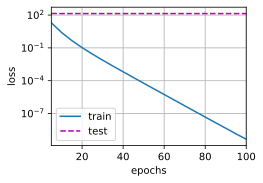

In [31]:
train_concise(0)

w的L2范数： 0.57357257604599


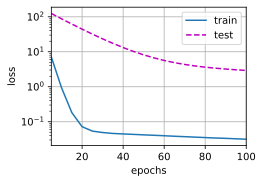

In [32]:
train_concise(3)

绘制训练和测试精度关于lambda的函数

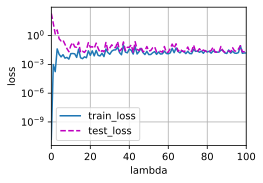

In [41]:
# 简洁实现
def train(wd):
    net = nn.Sequential(nn.Linear(num_inputs, 1))  # 定义网络
    for param in net.parameters():
        param.data.normal_()  # 初始化参数
    loss = nn.MSELoss(reduction='none')  # 损失
    num_epochs, lr = 100, 0.003
    # 设置参数衰减
    trainer = torch.optim.SGD([
        {'params':net[0].weight, 'weight_decay':wd},
        {'params':net[0].bias}], lr=lr)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(net(X), y)
            l.mean().backward()
            trainer.step()
    return d2l.evaluate_loss(net, train_iter, loss), d2l.evaluate_loss(net, test_iter, loss)

max_lambda = 100
animator = d2l.Animator(xlabel='lambda', ylabel='loss', yscale='log', xlim=[0, max_lambda], legend=['train_loss', 'test_loss'])
for l in range(max_lambda+1):
    l_train, l_test = train(l)
    animator.add(l, (l_train, l_test))